# Experiment 2: Problem as Multiclass classification
Use `Cross-entropy loss` for classification
Evaluate metrics by checking if `predicted index == monkeypox` index (5)

In [1]:
import torch
from torchvision.models import resnet50
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms

import numpy as np
import random
import os
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

set_seed(42)

In [3]:
def get_precision_recall_f1_accuracy(preds, actual):
    tp = torch.logical_and(preds, actual).sum().item()
    tn = torch.logical_and(torch.logical_not(preds), torch.logical_not(actual)).sum().item()
    fp = torch.logical_and(preds, torch.logical_not(actual)).sum().item()
    fn = torch.logical_and(torch.logical_not(preds), actual).sum().item()
    
    precision = tp / (tp + fp + 0.00001)
    recall = tp / (tp + fn + 0.00001)
    f1 = 2 * precision * recall / (precision + recall + 0.00001)
    accuracy = (tp + tn)/ (tp + tn + fp + fn + 0.00001)
    
    return precision, recall, f1, accuracy

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, indices, transform=None):
        self.image_paths = glob(os.path.join(root_dir, "*", "*"))
        self.indices = indices
        self.transform = transform
        
    def __len__(self):
        return len(self.indices)
    
    def __getitem__(self, index):
        idx = self.indices[index]
        image_path = self.image_paths[idx]
        image = Image.open(image_path).convert('RGB')
        disease = os.path.basename(os.path.dirname(image_path))
        
        return self.transform(image), torch.tensor(1 if disease == 'monkeypox' else 0)

In [5]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomResizedCrop((224, 224), (0.7, 1)),
    transforms.RandomRotation(15)
])
val_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    transforms.Resize((224, 224)),
])

In [6]:
data_dir = 'data/combined'
size = len(glob(os.path.join(data_dir, "*", "*")))
train_size = int(size * 0.8)
indices = list(range(size))
random.shuffle(indices)
train_set = CustomDataset(data_dir, indices[:train_size], train_transform)
val_set = CustomDataset(data_dir, indices[train_size:], val_transform)

In [7]:
train_loader = DataLoader(train_set, 8, shuffle=True)
val_loader = DataLoader(val_set, 8, shuffle=False)

In [8]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [15]:
model = resnet50()
# /home/dilith/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth
model.load_state_dict(torch.load("/home/dilith/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth"))
model.fc = torch.nn.Sequential(
    torch.nn.Linear(2048, 2),
    torch.nn.Softmax(dim=1)
)
# model.load_state_dict(torch.load("/home/dilith/Projects/monkeypox/models/best_model.pt"))
model = model.to(device)

In [16]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = torch.nn.CrossEntropyLoss()

In [17]:
metrics = {phase: {metric: [] for metric in ['loss', 'acc', 'prec', 'rec', 'f1']} for phase in ['train', 'val']}

In [18]:
best_loss = 1
for ep in range(50):
    print(f"------ Epoch {ep} ------")
    ep_metrics = {phase: {metric: 0 for metric in ['loss', 'acc', 'prec', 'rec', 'f1']} for phase in ['train', 'val']}
    for image, label in tqdm(train_loader):
        image = image.to(device)
        label = label.to(device)
        
        out = model(image).squeeze()
        loss = criterion(out, label)
        print(out)
        
        bsz = image.size(0)
        ep_metrics['train']['loss'] += loss.item() * bsz
        prec, rec, f1, acc = get_precision_recall_f1_accuracy(out[:, 1] > 0.5, label.bool())
        ep_metrics['train']['prec'] += prec * bsz
        ep_metrics['train']['rec'] += rec * bsz
        ep_metrics['train']['f1'] += f1 * bsz
        ep_metrics['train']['acc'] += acc * bsz
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        for image, label in tqdm(val_loader):
            image = image.to(device)
            label = label.to(device)
            
            out = model(image).squeeze()
            loss = criterion(out, label)
            
            bsz = image.size(0)
            ep_metrics['val']['loss'] += loss.item() * bsz
            prec, rec, f1, acc = get_precision_recall_f1_accuracy(out[:, 1] > 0.5, label.bool())
            ep_metrics['val']['prec'] += prec * bsz
            ep_metrics['val']['rec'] += rec * bsz
            ep_metrics['val']['f1'] += f1 * bsz
            ep_metrics['val']['acc'] += acc * bsz
    
    for phase in ep_metrics:
        for metric in ep_metrics[phase]:
            ep_metrics[phase][metric] /= len(train_set if phase == 'train' else val_set)
            metrics[phase][metric].append(ep_metrics[phase][metric])
    
    if ep_metrics['val']['loss'] < best_loss:
        best_loss = ep_metrics['val']['loss']
        torch.save(model.state_dict(), f'models/model_bin_1_{ep}.pt')
        print("Saved Model")
    
    for phase in ep_metrics:
        print("=>", phase)
        print(ep_metrics[phase])

------ Epoch 0 ------


  0%|          | 0/460 [00:00<?, ?it/s]

tensor([[0.5185, 0.4815],
        [0.5656, 0.4344],
        [0.4640, 0.5360],
        [0.4243, 0.5757],
        [0.3937, 0.6063],
        [0.4910, 0.5090],
        [0.3856, 0.6144],
        [0.3791, 0.6209]], device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([[0.5271, 0.4729],
        [0.4622, 0.5378],
        [0.4236, 0.5764],
        [0.4313, 0.5687],
        [0.4654, 0.5346],
        [0.4613, 0.5387],
        [0.4660, 0.5340],
        [0.3800, 0.6200]], device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([[0.4439, 0.5561],
        [0.4602, 0.5398],
        [0.5450, 0.4550],
        [0.4618, 0.5382],
        [0.5409, 0.4591],
        [0.4119, 0.5881],
        [0.5078, 0.4922],
        [0.3363, 0.6637]], device='cuda:0', grad_fn=<SqueezeBackward0>)
tensor([[0.4877, 0.5123],
        [0.4646, 0.5354],
        [0.4506, 0.5494],
        [0.4947, 0.5053],
        [0.4271, 0.5729],
        [0.4819, 0.5181],
        [0.4034, 0.5966],
        [0.5473, 0.4527]], device='cuda:0', grad_fn=<Squ

KeyboardInterrupt: 

In [89]:
import json
with open("metrics_bin_1.json", "w") as fp:
    json.dump(metrics, fp)

loss


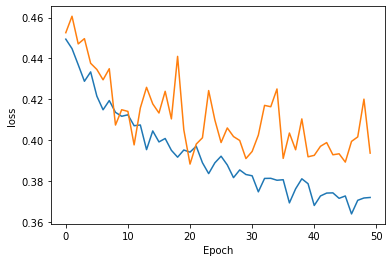

acc


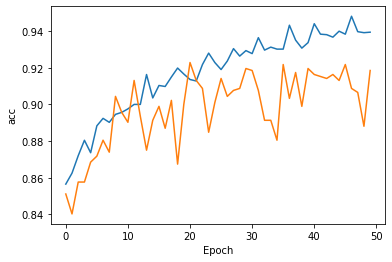

prec


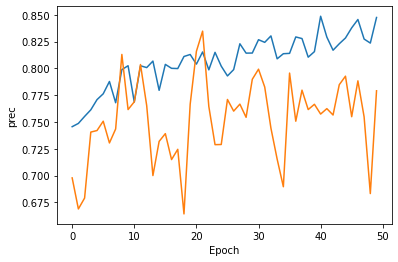

rec


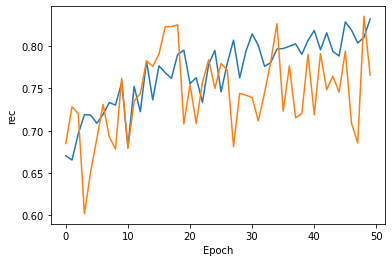

f1


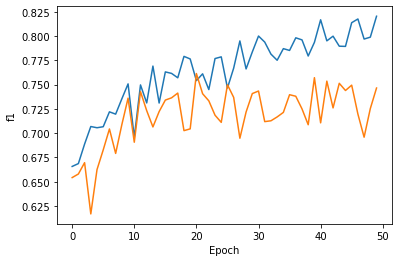

In [90]:
for metric in metrics["train"]:
    print(metric)
    for phase in metrics:
        plt.plot(range(len(metrics[phase][metric])), metrics[phase][metric])
    plt.xlabel("Epoch")
    plt.ylabel(metric)
    plt.show()

In [91]:
torch.save(model.state_dict(), f'models/model_bin_1_{ep}.pt')